<a href="https://colab.research.google.com/github/tibayo1/DL-Lung-Sounds/blob/master/Lung_Sounds_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import json

# read file
with open('/content/kaggle (1).json', 'r') as myfile:
    data=myfile.read()
# parse file
obj = json.loads(data)
#get username and key
kaggle_key = str(obj['key'])
kaggle_username = str(obj['username'])


In [3]:
import os

# parse file
obj = json.loads(data)

os.environ['KAGGLE_USERNAME'] = kaggle_username # username from the json file
os.environ['KAGGLE_KEY'] = kaggle_key # key from the json file
!kaggle datasets download -d "vbookshelf/respiratory-sound-database" # api copied from kaggle



100% 3.68G/3.69G [01:10<00:00, 12.4MB/s]
100% 3.69G/3.69G [01:10<00:00, 56.3MB/s]


In [0]:
#unzip the folder downloaded from kaggle
!unzip 'respiratory-sound-database.zip'

In [5]:
import os
import matplotlib.pyplot as plt

#for loading and visualizing audio files
import librosa
import librosa.display
import pandas as pd

#to play audio
import IPython.display as ipd

audio_fpath = "/content/"
audio_clips = os.listdir(audio_fpath)
print("No. of .wav files in audio folder = ",len(audio_clips))



No. of .wav files in audio folder =  7


In [6]:
os.listdir("/content/respiratory_sound_database/Respiratory_Sound_Database")

['patient_diagnosis.csv',
 'filename_differences.txt',
 'filename_format.txt',
 'audio_and_txt_files']

In [7]:
path = \
"../content/respiratory_sound_database/Respiratory_Sound_Database/audio_and_txt_files/154_2b4_Al_mc_AKGC417L.txt"

col_names = ['Beginning_of_respiratory_cycle', 'End_of_respiratory_cycle', 'Presence/absence_of_crackles', 'Presence/absence_of_wheezes']

# Respiratory cycle column values are in 'seconds'.
# Presence = 1
# Absence = 0

df_annot = pd.read_csv(path, sep="\t", header=None, names=col_names)

df_annot.head(30)

,Beginning_of_respiratory_cycle,End_of_respiratory_cycle,Presence/absence_of_crackles,Presence/absence_of_wheezes
0,1.330,3.804,0,0
1,3.804,6.396,0,0
2,6.396,8.938,1,0
3,8.938,11.580,1,0
4,11.580,14.072,1,0
5,14.072,17.049,1,0
6,17.049,19.490,1,0


In [0]:
! pip install pysoundfile

In [0]:
import soundfile as sf

# Define helper functions

# Load a .wav file. 
# These are 24 bit files. The PySoundFile library is able to read 24 bit files.
# https://pysoundfile.readthedocs.io/en/0.9.0/

def get_wav_info(wav_file):
    data, rate = sf.read(wav_file)
    return data, rate

# source: Andrew Ng Deep Learning Specialization, Course 5
def graph_spectrogram(wav_file):
    data, rate = get_wav_info(wav_file)
    nfft = 200 # Length of each window segment
    fs = 8000 # Sampling frequencies
    noverlap = 120 # Overlap between windows
    nchannels = data.ndim
    if nchannels == 1:
        pxx, freqs, bins, im = plt.specgram(data, nfft, fs, noverlap = noverlap)
    elif nchannels == 2:
        pxx, freqs, bins, im = plt.specgram(data[:,0], nfft, fs, noverlap = noverlap)
    return pxx

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:7581: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


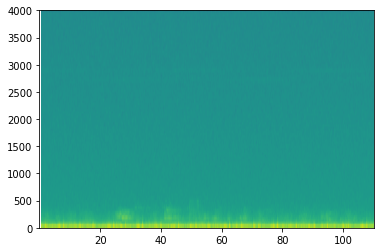

In [11]:
path = \
'../content/respiratory_sound_database/Respiratory_Sound_Database/audio_and_txt_files/154_2b4_Al_mc_AKGC417L.wav'


x = graph_spectrogram(path)

In [13]:
x, sr = librosa.load(path, sr=44100)

print(type(x), type(sr))
print(x.shape, sr)

<class 'numpy.ndarray'> <class 'int'>
(882000,) 44100


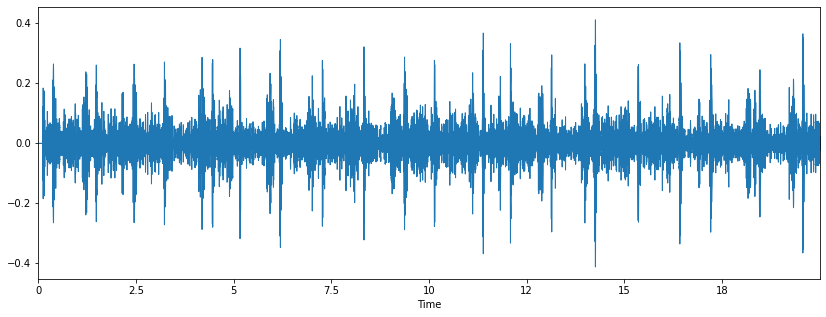

In [14]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(x, sr=sr)